In [1]:
from pyqode.solver import Solver
import numpy as np
from pyqode.nozzle_2d import nasa_cdv_nozzle_verification_geometry
from pyqode.utils import r_to_k, psi_to_pa, meter_to_inch, area_to_radius, inch_to_meter, ft_to_meter, pa_to_psi, radius_to_area
import matplotlib.pyplot as plt
from pyqode.solver import PostProcessor, gen_su2_setup, gen_multizone_su2_setup
from pathlib import Path
import numpy as np
import pandas as pd
from pyqode.nozzle_2d import gen_nozzle_mesh, gen_wall_mesh, gen_multizone_mesh
from pyqode.solver import SU2Solver
import pyvista as pv

Q1D_SOLVER = '/home/ppiper/Documents/doctorate/src/pyqode/pyqode/src/eulerQ1D'
GMSH = '/home/ppiper/Documents/doctorate/src/pyqode/pyqode/src/gmsh'
SU2_TEMPLATE = './template_fluid_su2_symmetry.cfg'
SU2_SOLVER = '/home/ppiper/Documents/doctorate/src/pyqode/pyqode/src/SU2-v8.0.0-linux64/bin/SU2_CFD'

def run_1D(config):
    eq1d = Solver(config = config, executable=Q1D_SOLVER)
    eq1d.run()

    # nozzle geometry
    plt.figure()
    plt.axis('equal')
    plt.plot( config['domain_x'], area_to_radius(config['domain_area']), color='k')
    plt.plot( config['domain_x'], -area_to_radius(config['domain_area']), color='k')
    plt.show()

    # post processor 
    pp = PostProcessor(f"{config['working_dir']}/outputs")

    # pressure
    #plt.plot(pp.x,pp.p)

    # mach
    #plt.plot(meter_to_inch(pp.x),pp.M)

    # residues
    plt.figure()
    plt.plot(pp.rese)
    plt.plot(pp.resrho)
    plt.plot(pp.resrhou)

    plt.yscale('log')
    plt.show()


# mesh coarse
#Nx = 50
#Ny = 20
#inflation_rate = 1.2
# CFL = 0.01

# mesh coarse
#Nx = 100
#Ny = 40
#inflation_rate = 1.1
# CFL = 0.01

# yplu2 
#Nx=60,
#        Ny=20,
#       inflation_rate=1.6,

# yplu 1.2
#Nx=100,
#Ny=35,
#inflation_rate=1.3,
#10^-4 in 1684 iterations

######
#coarse
#60x20 + bl = 1888 cells
#medium
#85x25
#fine
#120x30


def run_2D(config):
    config_su2 = config
    domain_mesh = Path(config['working_dir']).resolve() / 'mesh' / 'nozzle.su2'
    config_su2['domain_mesh'] = domain_mesh
    nozzle_mesh_file = gen_nozzle_mesh(
        xn=config['domain_x'],
        rn=area_to_radius(config['domain_area']),
        Nx=400+1, #200+1,#100,150
        Ny=90+1, #20,20,15,
        inflation_rate=1.00,
        output_file=  domain_mesh,
        gmshsolver = GMSH,
        symmetry= True if config['domain_axisymmetric'] == 'YES' else False,
        using='Progression', 
        hwall_n=0.000005,
        thickness=0.01,
        ratio=1.2,
        beta=1.01, #1.001,1.001,1.001, 
        nblayers=10 #20,#10,10
    )
    
    nozzle_mesh_file = Path(nozzle_mesh_file).with_suffix('.su2')

    fluid_cfg = gen_su2_setup(
        template=SU2_TEMPLATE,
        config=config_su2,
        output_file= Path(Path(config['working_dir']) / 'fluid.cfg').resolve()
    )

    su2 = SU2Solver(
    config_file = fluid_cfg, 
    executable = SU2_SOLVER,
    )
    
    su2.run()



def plot_validation(config_1D, config_2D, P0IN_PSI):

    data_valid= pd.read_csv('/home/ppiper/Documents/doctorate/src/pyqode/examples/back/data/wpd_datasets.csv', delimiter=',', header=0)
    
    pp = PostProcessor(f"{config_1D['working_dir']}/outputs")

    vtu = pv.read(f"{config_2D['working_dir']}/flow.vtm")
    vtu[0]['Boundary']['UPPER_WALL']

    p = pv.Plotter()
    p.add_mesh(vtu, scalars='Pressure')
    p.show(cpos='xy')
    
    #center = pd.DataFrame({'x':vtu[0]['Boundary']['SYMMETRY'].points[:,0], 
    #              'pressure':vtu[0]['Boundary']['SYMMETRY']['Pressure']})
    #center.sort_values(by=['x'], inplace=True)

    upper = pd.DataFrame({'x':vtu[0]['Boundary']['UPPER_WALL'].points[:,0],
                    'pressure':vtu[0]['Boundary']['UPPER_WALL']['Pressure']})
    upper.sort_values(by=['x'], inplace=True)
    
    plt.figure()
    #p0_in_psi = pa_to_psi(config['bc_p0'])
    plt.plot(pp.x,pp.p/psi_to_pa(P0IN_PSI), label='1D')
    plt.plot(upper['x'], upper['pressure'], label='2D-wall')
    plt.scatter(inch_to_meter(data_valid[f'X_{P0IN_PSI:.1f}']), data_valid[f'Y_{P0IN_PSI:.1f}'], label='validation')
    plt.legend()
    plt.xlabel('x [m]')
    plt.ylabel('p/p0')
    plt.title(f'Validation at p0={P0IN_PSI:.1f} psi')
    plt.savefig(f'pressure_validation_{P0IN_PSI:.1f}.png', dpi=300, bbox_inches='tight')
    plt.show()

    x_ = pp.x


In [2]:
#coarse
#Nx=60,
#Ny=30,
#inflation_rate=1.35,

# medium
#Nx=80,
#Ny=40,
#inflation_rate=1.23,

# fine
#Nx=110,
#Ny=50,
#inflation_rate=1.23

#Nx=60,
#        Ny=25,
#        inflation_rate=1.38,

#Nx=90,
#        Ny=30,
#        inflation_rate=1.28,

#Nx=120,
#        Ny=40,
#        inflation_rate=1.23,


In [3]:
data = pd.read_csv('/home/ppiper/Documents/doctorate/src/pyqode/examples/back/data/geometry.asc', skiprows=1, delimiter=' ', header=None)
data.sort_values(by=[0], inplace=True)
xn_in = data.values[:, 0]
rn_in = data.values[:, 1]
xn = xn_in/1000
rn = rn_in/1000
sn = radius_to_area(rn)


P0IN_PSI_LIST = [45.1, 60.1, 75.0, 100.6, 150.4, 199.6, 250.2]
T0IN = r_to_k(1500)
PB = 101.325e3
GAMMA = 1.35
R = 287.0
AXISYMMETRIC = 'YES'
    

################################################################################
                           -*- Q1D Euler Solver -*-
Eigen 3.3.7
Allan Moreira de Carvalho
################################################################################
                           -*- Setup Information -*-
################################################################################
# Domain x-coordinates at cell faces (no need for ghost cells)
/home/ppiper/Documents/doctorate/src/pyqode/examples/back/1D/45.1/inputs/xn.txt
# Area distributuin at cell faces (no need for ghost cells)
/home/ppiper/Documents/doctorate/src/pyqode/examples/back/1D/45.1/inputs/sn.txt
# Inlet Total Pressure [Pa]
310953.67600000004
# Inlet Total Temperature [K]
833.3333333333333
# Inlet Mach Number
0.0001
# Outlet Static Pressure [Pa]
101325.0
# Gas constant [J/kg/K]
287.0
# Specific heat ratio
1.35
# Maximum number of iterations 
50000
# Interval to print iterations 
1.01
# CFL number 
0.5
# Convergence criter

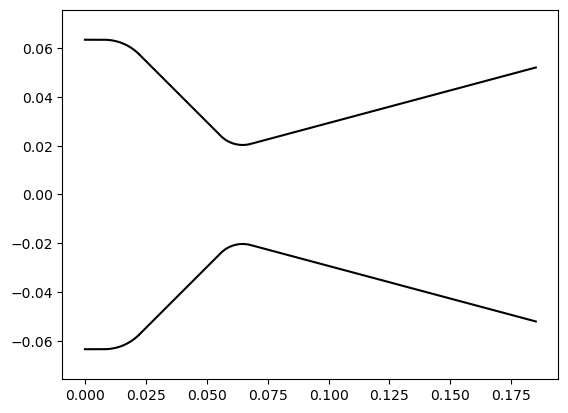

c
T
resrhou
e
x
resrho
rese
S
rho
u
M
p


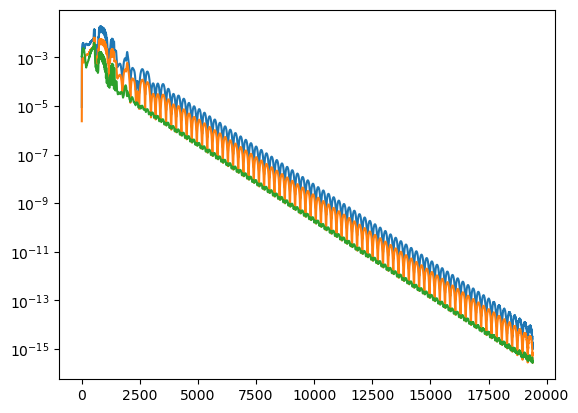

Info    : Running '/home/ppiper/Documents/doctorate/src/pyqode/pyqode/src/gmsh /home/ppiper/Documents/doctorate/src/pyqode/examples/back/2D/45.1/mesh/nozzle.geo -0 -2 -format su2 -o /home/ppiper/Documents/doctorate/src/pyqode/examples/back/2D/45.1/mesh/nozzle.su2' [Gmsh 4.9.1, 1 node, max. 1 thread]
Info    : Started on Wed Oct 11 11:53:58 2023
Info    : Reading '/home/ppiper/Documents/doctorate/src/pyqode/examples/back/2D/45.1/mesh/nozzle.geo'...
Info    : Done reading '/home/ppiper/Documents/doctorate/src/pyqode/examples/back/2D/45.1/mesh/nozzle.geo'
Info    : Meshing 1D...
Info    : [  0%] Meshing curve 1 (Line)
Info    : [ 30%] Meshing curve 2 (Line)
Info    : [ 50%] Meshing curve 3 (Line)
Info    : [ 80%] Meshing curve 4 (Line)
Info    : Done meshing 1D (Wall 0.00252696s, CPU 0.004493s)
Info    : Meshing 2D...
Info    : Meshing surface 1 (Transfinite)
Info    : Done meshing 2D (Wall 0.00788242s, CPU 0.021309s)
Info    : 41335 nodes 41838 elements
Info    : Writing '/home/ppiper/Do

/home/ppiper/micromamba/envs/pyqode/lib/python3.10/site-packages/pyvista/jupyter/notebook.py:33: UserWarning: Failed to use notebook backend: 

No module named 'trame'

Falling back to a static output.
  warnings.warn(


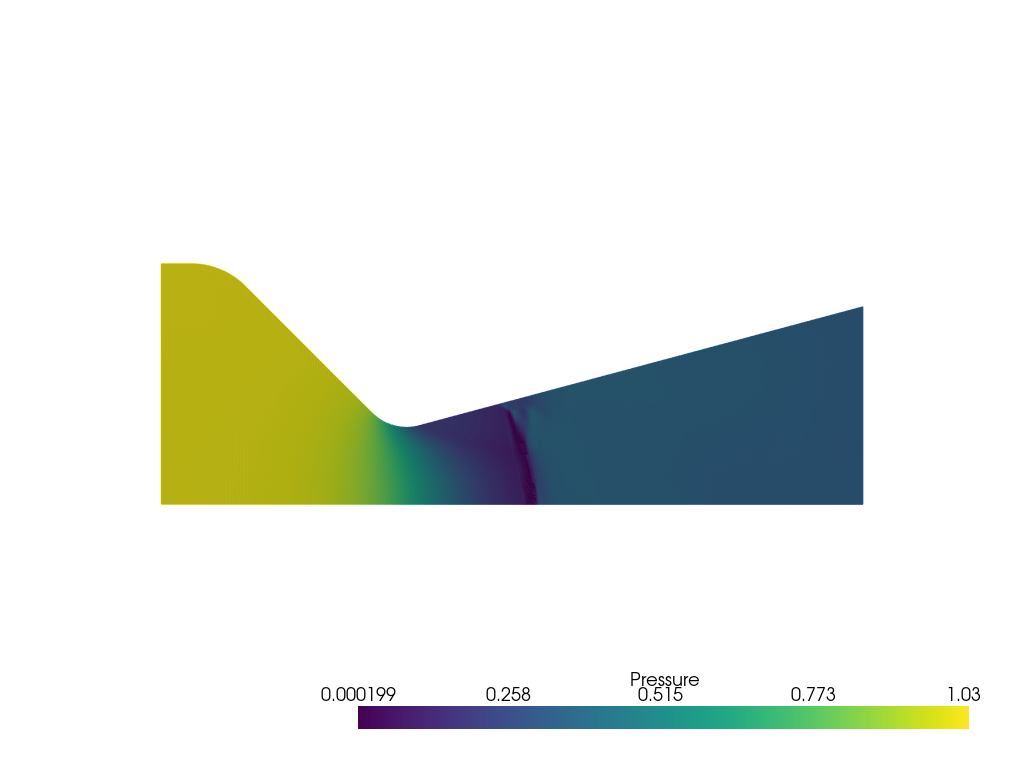

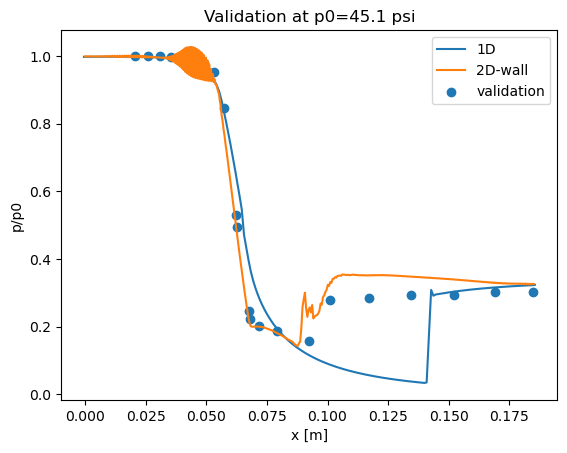

################################################################################
                           -*- Q1D Euler Solver -*-
Eigen 3.3.7
Allan Moreira de Carvalho
################################################################################
                           -*- Setup Information -*-
################################################################################
# Domain x-coordinates at cell faces (no need for ghost cells)
/home/ppiper/Documents/doctorate/src/pyqode/examples/back/1D/60.1/inputs/xn.txt
# Area distributuin at cell faces (no need for ghost cells)
/home/ppiper/Documents/doctorate/src/pyqode/examples/back/1D/60.1/inputs/sn.txt
# Inlet Total Pressure [Pa]
414375.076
# Inlet Total Temperature [K]
833.3333333333333
# Inlet Mach Number
0.0001
# Outlet Static Pressure [Pa]
101325.0
# Gas constant [J/kg/K]
287.0
# Specific heat ratio
1.35
# Maximum number of iterations 
50000
# Interval to print iterations 
1.01
# CFL number 
0.5
# Convergence criteria 
1e-1

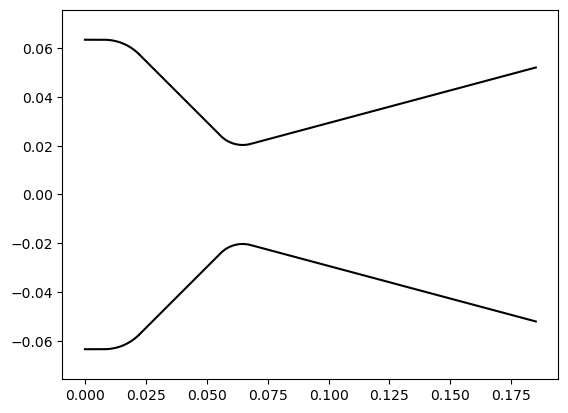

c
T
resrhou
e
x
resrho
rese
S
rho
u
M
p


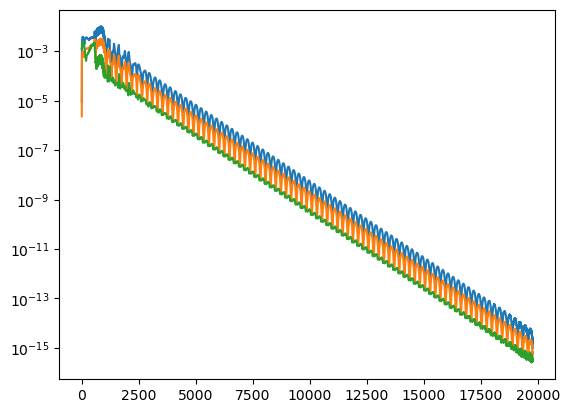

Info    : Running '/home/ppiper/Documents/doctorate/src/pyqode/pyqode/src/gmsh /home/ppiper/Documents/doctorate/src/pyqode/examples/back/2D/60.1/mesh/nozzle.geo -0 -2 -format su2 -o /home/ppiper/Documents/doctorate/src/pyqode/examples/back/2D/60.1/mesh/nozzle.su2' [Gmsh 4.9.1, 1 node, max. 1 thread]
Info    : Started on Wed Oct 11 12:15:39 2023
Info    : Reading '/home/ppiper/Documents/doctorate/src/pyqode/examples/back/2D/60.1/mesh/nozzle.geo'...
Info    : Done reading '/home/ppiper/Documents/doctorate/src/pyqode/examples/back/2D/60.1/mesh/nozzle.geo'
Info    : Meshing 1D...
Info    : [  0%] Meshing curve 1 (Line)
Info    : [ 30%] Meshing curve 2 (Line)
Info    : [ 50%] Meshing curve 3 (Line)
Info    : [ 80%] Meshing curve 4 (Line)
Info    : Done meshing 1D (Wall 0.00245642s, CPU 0.007647s)
Info    : Meshing 2D...
Info    : Meshing surface 1 (Transfinite)
Info    : Done meshing 2D (Wall 0.00762556s, CPU 0.018732s)
Info    : 41335 nodes 41838 elements
Info    : Writing '/home/ppiper/Do

/home/ppiper/micromamba/envs/pyqode/lib/python3.10/site-packages/pyvista/jupyter/notebook.py:33: UserWarning: Failed to use notebook backend: 

No module named 'trame'

Falling back to a static output.
  warnings.warn(


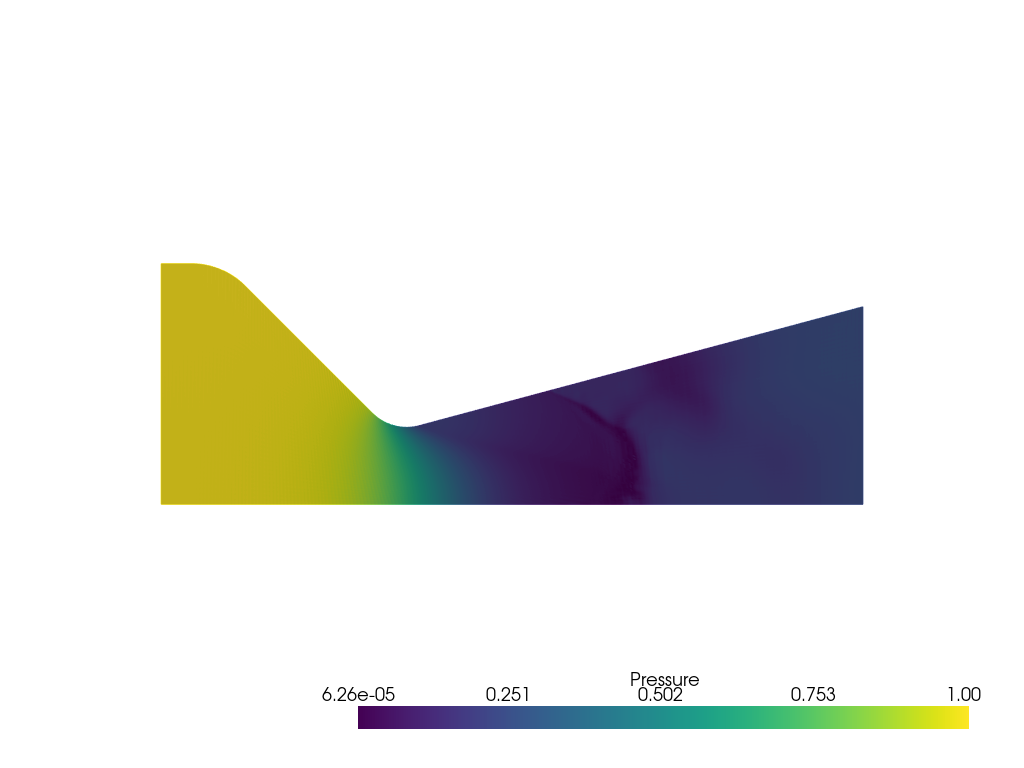

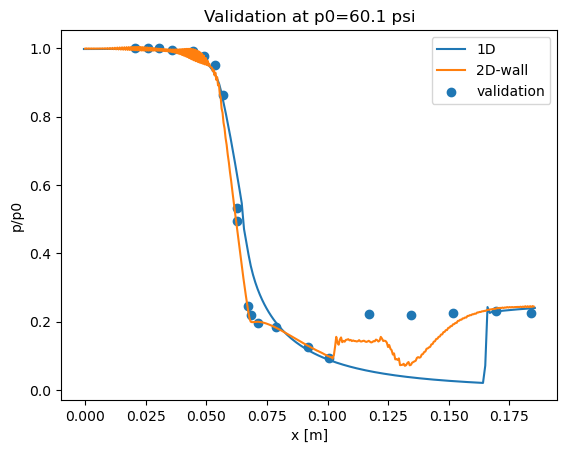

################################################################################
                           -*- Q1D Euler Solver -*-
Eigen 3.3.7
Allan Moreira de Carvalho
################################################################################
                           -*- Setup Information -*-
################################################################################
# Domain x-coordinates at cell faces (no need for ghost cells)
/home/ppiper/Documents/doctorate/src/pyqode/examples/back/1D/75.0/inputs/xn.txt
# Area distributuin at cell faces (no need for ghost cells)
/home/ppiper/Documents/doctorate/src/pyqode/examples/back/1D/75.0/inputs/sn.txt
# Inlet Total Pressure [Pa]
517107.0
# Inlet Total Temperature [K]
833.3333333333333
# Inlet Mach Number
0.0001
# Outlet Static Pressure [Pa]
101325.0
# Gas constant [J/kg/K]
287.0
# Specific heat ratio
1.35
# Maximum number of iterations 
50000
# Interval to print iterations 
1.01
# CFL number 
0.5
# Convergence criteria 
1e-15


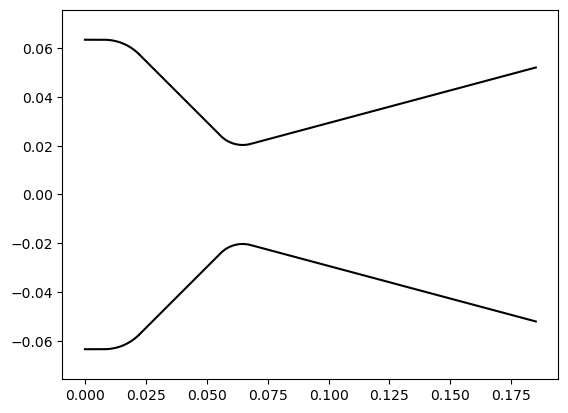

c
T
resrhou
e
x
resrho
rese
S
rho
u
M
p


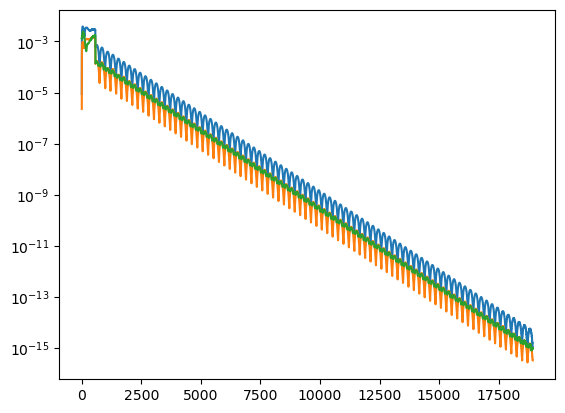

Info    : Running '/home/ppiper/Documents/doctorate/src/pyqode/pyqode/src/gmsh /home/ppiper/Documents/doctorate/src/pyqode/examples/back/2D/75.0/mesh/nozzle.geo -0 -2 -format su2 -o /home/ppiper/Documents/doctorate/src/pyqode/examples/back/2D/75.0/mesh/nozzle.su2' [Gmsh 4.9.1, 1 node, max. 1 thread]
Info    : Started on Wed Oct 11 12:21:48 2023
Info    : Reading '/home/ppiper/Documents/doctorate/src/pyqode/examples/back/2D/75.0/mesh/nozzle.geo'...
Info    : Done reading '/home/ppiper/Documents/doctorate/src/pyqode/examples/back/2D/75.0/mesh/nozzle.geo'
Info    : Meshing 1D...
Info    : [  0%] Meshing curve 1 (Line)
Info    : [ 30%] Meshing curve 2 (Line)
Info    : [ 50%] Meshing curve 3 (Line)
Info    : [ 80%] Meshing curve 4 (Line)
Info    : Done meshing 1D (Wall 0.00243279s, CPU 0.005408s)
Info    : Meshing 2D...
Info    : Meshing surface 1 (Transfinite)
Info    : Done meshing 2D (Wall 0.00733885s, CPU 0.014584s)
Info    : 41335 nodes 41838 elements
Info    : Writing '/home/ppiper/Do

/home/ppiper/micromamba/envs/pyqode/lib/python3.10/site-packages/pyvista/jupyter/notebook.py:33: UserWarning: Failed to use notebook backend: 

No module named 'trame'

Falling back to a static output.
  warnings.warn(


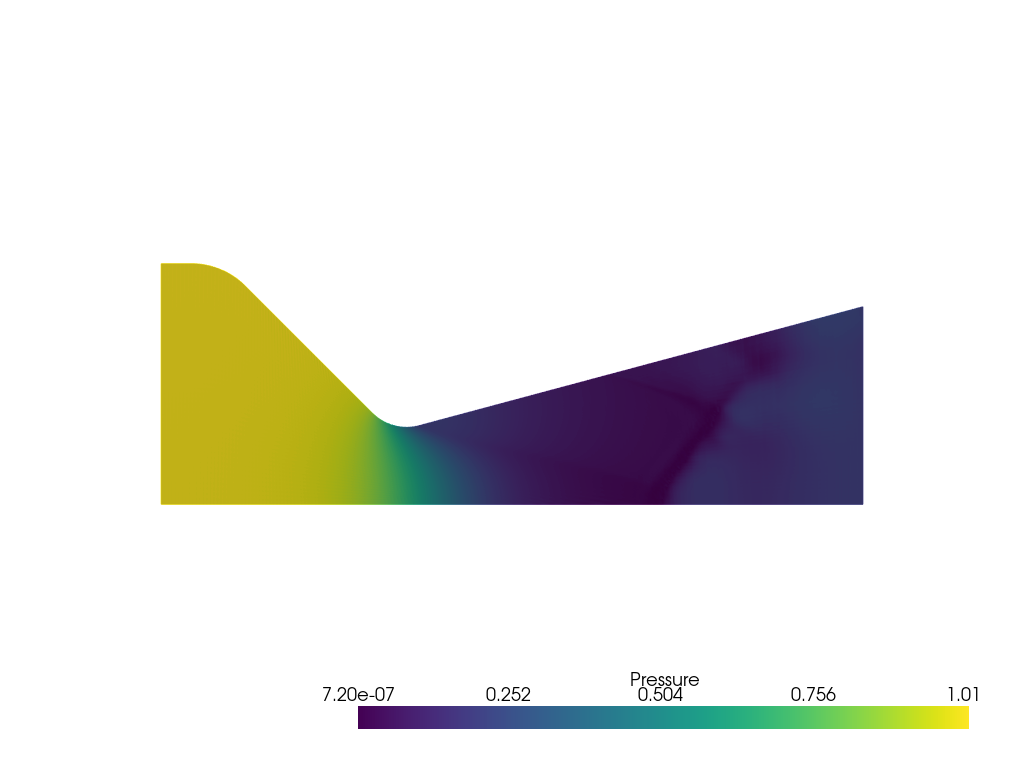

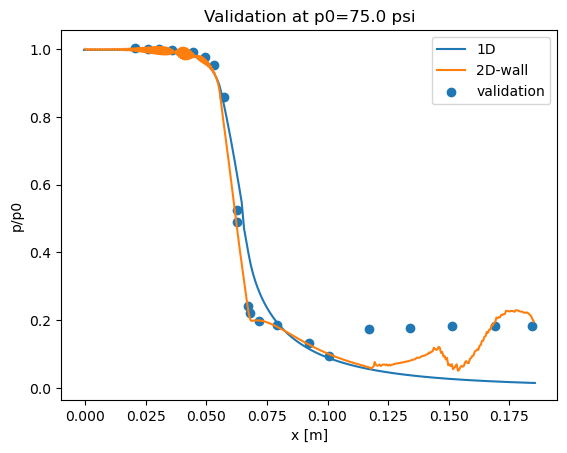

################################################################################
                           -*- Q1D Euler Solver -*-
Eigen 3.3.7
Allan Moreira de Carvalho
################################################################################
                           -*- Setup Information -*-
################################################################################
# Domain x-coordinates at cell faces (no need for ghost cells)
/home/ppiper/Documents/doctorate/src/pyqode/examples/back/1D/100.6/inputs/xn.txt
# Area distributuin at cell faces (no need for ghost cells)
/home/ppiper/Documents/doctorate/src/pyqode/examples/back/1D/100.6/inputs/sn.txt
# Inlet Total Pressure [Pa]
693612.856
# Inlet Total Temperature [K]
833.3333333333333
# Inlet Mach Number
0.0001
# Outlet Static Pressure [Pa]
101325.0
# Gas constant [J/kg/K]
287.0
# Specific heat ratio
1.35
# Maximum number of iterations 
50000
# Interval to print iterations 
1.01
# CFL number 
0.5
# Convergence criteria 
1e

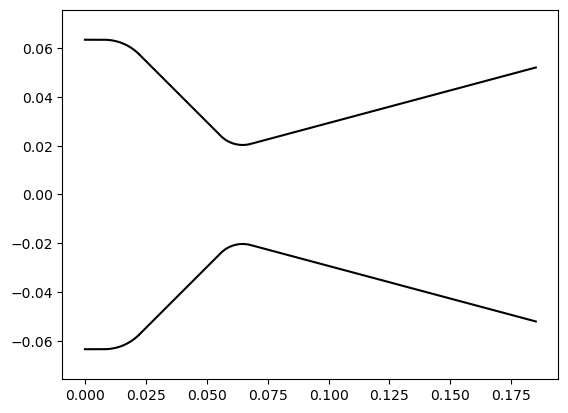

c
T
resrhou
e
x
resrho
rese
S
rho
u
M
p


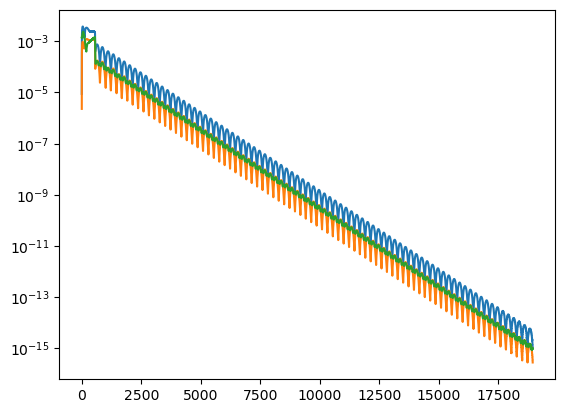

Info    : Running '/home/ppiper/Documents/doctorate/src/pyqode/pyqode/src/gmsh /home/ppiper/Documents/doctorate/src/pyqode/examples/back/2D/100.6/mesh/nozzle.geo -0 -2 -format su2 -o /home/ppiper/Documents/doctorate/src/pyqode/examples/back/2D/100.6/mesh/nozzle.su2' [Gmsh 4.9.1, 1 node, max. 1 thread]
Info    : Started on Wed Oct 11 17:36:48 2023
Info    : Reading '/home/ppiper/Documents/doctorate/src/pyqode/examples/back/2D/100.6/mesh/nozzle.geo'...
Info    : Done reading '/home/ppiper/Documents/doctorate/src/pyqode/examples/back/2D/100.6/mesh/nozzle.geo'
Info    : Meshing 1D...
Info    : [  0%] Meshing curve 1 (Line)
Info    : [ 30%] Meshing curve 2 (Line)
Info    : [ 50%] Meshing curve 3 (Line)
Info    : [ 80%] Meshing curve 4 (Line)
Info    : Done meshing 1D (Wall 0.0024829s, CPU 0.006622s)
Info    : Meshing 2D...
Info    : Meshing surface 1 (Transfinite)
Info    : Done meshing 2D (Wall 0.00782255s, CPU 0.031487s)
Info    : 41335 nodes 41838 elements
Info    : Writing '/home/ppiper

KeyboardInterrupt: 

 2483|   -6.995552|   -6.854299|   -6.421467|   -8.523000|   -3.116053|
|        2484|   -7.004713|   -6.853981|   -6.430369|   -8.508310|   -3.061461|
|        2485|   -7.014158|   -6.853921|   -6.439834|   -8.491960|   -3.015864|
|        2486|   -7.018651|   -6.853474|   -6.444199|   -8.465433|   -2.997308|
|        2487|   -7.020618|   -6.850230|   -6.445627|   -8.442257|   -3.012106|
|        2488|   -7.017578|   -6.845711|   -6.443477|   -8.423767|   -3.060448|
|        2489|   -7.019912|   -6.844451|   -6.447828|   -8.416015|   -3.140642|
|        2490|   -7.037614|   -6.848743|   -6.467935|   -8.420380|   -3.240859|
+-----------------------------------------------------------------------+
|        File Writing Summary       |              Filename             |
+-----------------------------------------------------------------------+
|SU2 binary restart                 |restart.dat                        |
+-----------------------------------------------------------------------

In [4]:
for P0IN_PSI in P0IN_PSI_LIST[:]:
    P0IN = psi_to_pa(P0IN_PSI)

    config_1D = {
        'working_dir': f'./1D/{P0IN_PSI}',
        'domain_x': xn,
        'domain_area': sn,
        'domain_size': 200,
        'bc_p0': P0IN,
        'bc_T0': T0IN ,
        'bc_M': 0.0001,
        'bc_pb': PB,
        'fluid_R': R,
        'fluid_gamma': GAMMA,
        'solver_itmax': 50000,
        'solver_itprint': 1.01,
        'solver_CFL': 0.5,
        'solver_tol': 1e-15,
        'solver_tscheme': 'Euler',
        'solver_fscheme': 'AUSM',
        'solver_dttype': 'Global',
        'solver_dim': 'Dimensionless',  
    }

    config_2D = {
        'working_dir': f'./2D/{P0IN_PSI}',
        'domain_x': xn,
        'domain_area': sn,
        'turbulence_model': 'SST',
        'solver_dim': 'FREESTREAM_PRESS_EQ_ONE',
        'fluid': 'IDEAL_GAS',
        'fluid_gamma': GAMMA,
        'fluid_R': R,
        'fluid_critical_temperature': 131.00,
        'fluid_critical_pressure': 3588550.0,
        'fluid_accentric_factor': 0.035,
        'fluid_viscosity_model': 'SUTHERLAND', 
        'fluid_sutherland_viscosity': 1.716E-5,
        'fluid_sutherland_temperature': 273.15,
        'fluid_sutherland_constant': 110.4,
        'fluid_conductivity_model': 'CONSTANT_PRANDTL',
        'fluid_laminar_prandtl': 0.72,
        'fluid_turbulent_prandtl': 0.9,
        'solver_CFL': 0.01,
        'domain_axisymmetric': AXISYMMETRIC,
        'bc_p0': P0IN,
        'bc_T0': T0IN,
        'bc_M': 0.0001,
        'bc_pb': PB,
        'solver_itmax': 3000,
        'solver_tol': np.log10(1e-6),
        'solver_tscheme': 'EULER_IMPLICIT',
        'solver_fscheme': 'JST_KE',
        'solver_dttype': 'Global',
        'output_files': 'PARAVIEW',
    }

    run_1D(config_1D)
    run_2D(config_2D)

    # validation plot
    plot_validation(config_1D, config_2D, P0IN_PSI)

In [ ]:
vtu = pv.read(f"{config_2D['working_dir']}/flow.vtm")
np.max(vtu[0]['Boundary']['UPPER_WALL']['Y_Plus'])

In [ ]:
vtu[0][0][0]